In [3]:
import scipy as sp
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab
import os
import matplotlib.pyplot as plt
data = pd.read_csv('dating.csv')
bins = [2, 5, 10, 50, 100, 200]
#bins=[2,10]
t_frac = 1
def getdict(key,val):
    dict_sub = {}
    for j in range(len(key)):
        dict_sub[key[j]] = float(val[j])/sum(val) 
    return dict_sub

dict_final={}
def getdictfinal_yes(df,list_col):
    for i in list_col:
        #print i
        key =  df[i].value_counts().keys().tolist()
        #print key
        val = df[i].value_counts().tolist()
        #print val
        dict_sub = getdict(key,val)
        dict_final[i]=dict_sub
    return dict_final

def getdict(key,val):
    dict_sub = {}
    for j in range(len(key)):
        dict_sub[key[j]] = float(val[j])/sum(val) 
    return dict_sub

dict_final1={}
def getdictfinal_no(df1,list_col):
    for i in list_col: 
        key1 =  df1[i].value_counts().keys().tolist()
        #print key1
        val1 = df1[i].value_counts().tolist()
        #print val1
        dict_sub = getdict(key1,val1)
        dict_final1[i]=dict_sub
    return dict_final1

def nbc(t_frac,data):
    train=data.sample(random_state=47,frac=t_frac)
    train_yes = train[train['decision'] == 1] 
    train_no = train[train['decision'] == 0]
    list_col =  list(data.columns)
    list_col_full =  list(data.columns)
    list_col.remove('decision')
    dict_yes = getdictfinal_yes(train_yes,list_col)
    dict_no = getdictfinal_no(train_no,list_col)
    return dict_yes,dict_no
dict_yes,dict_no = nbc(t_frac,data)

def calc_conditional_prob(df,yes_or_no_prob,list_col):
    df['new']=1
    for i in list_col:
        df['new'] = df['new'] * df[i]
    df['new'] = df['new'] * yes_or_no_prob
    return df['new']

def getaccuracy(df,dict_yes,dict_no,list_col):
    yes_prob = float((df.decision==1).sum())/((df.decision==1).sum()+(df.decision==0).sum())
    no_prob = 1 -yes_prob
    mod_yes = df[list_col]    
    for i in list_col:
        mod_yes[i] = mod_yes[i].map(dict_yes[i]) 
    
    mod_no = df[list_col]
    for i in list_col:
        mod_no[i] = mod_no[i].map(dict_no[i])
    df['conditionalyes'] = calc_conditional_prob(mod_yes,yes_prob,list_col)
    df['conditionalno'] = calc_conditional_prob(mod_no,no_prob,list_col)
    df['prediction'] = 0
    df.loc[(df['conditionalyes'] >= df['conditionalno']), 'prediction'] = 1
    df['accuracy'] = abs(df['decision']-df['prediction'])
    accuracy =  round(float((df.accuracy==0).sum())/((df.accuracy==0).sum()+(df.accuracy==1).sum()),2)
    return accuracy

list_nobins = ['gender','race','race_o','samerace','field']
list_col_part1=['attractive_important','sincere_important','intelligence_important',\
        'funny_important','ambition_important','shared_interests_important',\
        'pref_o_attractive','pref_o_sincere','pref_o_intelligence',\
        'pref_o_funny','pref_o_ambitious','pref_o_shared_interests']
list_col_age=['age','age_o']
list_Range_10 = ['importance_same_race','importance_same_religion','attractive', 'sincere',\
                 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner',\
                 'intelligence_parter', 'funny_partner', 'ambition_partner', \
                 'shared_interests_partner', 'sports', 'tvsports', 'exercise',\
                 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',\
                 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',\
                 'expected_happy_with_sd_people', 'like']
list_correlate = ['interests_correlate']
minval_age=18
maxval_age=58
minval_part1=0
maxval_part1=1
minval_range10 =0
maxval_Range10=10
minval_correlate=-1
maxval_correlate=1

training_acc = []
test_acc=[]
for i in bins:
    print "Bin size:",i
    list_col =  list(data.columns.values)
    list_col.remove('decision')
    bin = data[list_col] 
    for j in list_col:
        if j in list_nobins:
            bin[j] =  bin[j]
        elif j in list_col_part1:
            bin[j] = pd.cut(bin[j], bins = \
                            np.linspace(minval_part1, maxval_part1, i+1),\
                            include_lowest=True,labels=range(i))
        elif j in list_col_age:
            bin[j] = pd.cut(bin[j],bins = np.linspace(minval_age, maxval_age, i+1)\
                            ,include_lowest=True,labels=range(i))
        elif j in list_Range_10:
            bin[j] = pd.cut(bin[j], bins = np.linspace(minval_range10, maxval_Range10, i+1)\
                            ,include_lowest=True,labels=range(i))
        elif j in list_correlate:
            bin[j] = pd.cut(bin[j], bins = np.linspace(minval_correlate, maxval_correlate, i+1)\
                              ,include_lowest=True,labels=range(i))
        else:
            bin[j] = pd.cut(bin[j], i, labels=range(i))
    bin['decision'] = data['decision']
    data_test = bin.sample(random_state=47,frac=0.2)
    data_train = bin[~bin.index.isin(data_test.index)]
    dict_yes,dict_no = nbc(t_frac,data_train)
    f = dict_yes['field']
    Train_accuracy= getaccuracy(data_train,dict_yes,dict_no,list_col)
    print "Training Accuracy:", Train_accuracy
    Test_accuracy= getaccuracy(data_test,dict_yes,dict_no,list_col)
    print "Test Accuracy:", Test_accuracy
    training_acc.append(Train_accuracy)
    test_acc.append(Test_accuracy)

Bin size: 2
Training Accuracy: 0.74
Test Accuracy: 0.71
Bin size: 5


KeyboardInterrupt: 

In [2]:
x = bins
y = test_acc
y0= training_acc
area = np.pi*10
#plt.scatter(x, y, s=area, c='g',alpha=0.5,label = "Test")
#plt.scatter(x, y0, s=area, c='b',alpha=0.5,label = "Train")
plt.scatter(x, y, label = 'Testing')
plt.scatter(x, y0, label = 'Training')
plt.title('Testing vs Training Data Accuracy',fontsize=24,color='purple')
plt.xlabel('Number of Bins',fontsize=14,color='purple')
plt.ylabel('Accuracy',fontsize=14,color='purple')
plt.legend(loc='upper right')
plt.savefig('Fig-5_2.png')
#plt.show()
plt.close()

NameError: name 'bins' is not defined

In [2]:
list_nobins = ['gender','race','race_o','samerace','field']
list_col_part1=['attractive_important','sincere_important','intelligence_important',\
        'funny_important','ambition_important','shared_interests_important',\
        'pref_o_attractive','pref_o_sincere','pref_o_intelligence',\
        'pref_o_funny','pref_o_ambitious','pref_o_shared_interests']
list_col_age=['age','age_o']
list_Range_10 = ['importance_same_race','importance_same_religion','attractive', 'sincere',\
                 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner',\
                 'intelligence_parter', 'funny_partner', 'ambition_partner', \
                 'shared_interests_partner', 'sports', 'tvsports', 'exercise',\
                 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',\
                 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',\
                 'expected_happy_with_sd_people', 'like']
list_correlate = ['interests_correlate']
minval_age=18
maxval_age=58
minval_part1=0
maxval_part1=1
minval_range10 =0
maxval_Range10=10
minval_correlate=-1
maxval_correlate=1

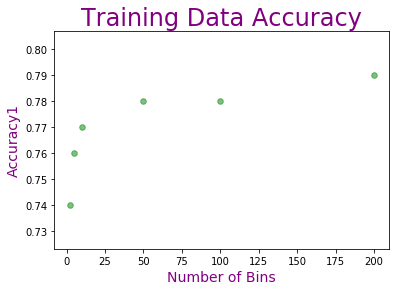

In [11]:
x = bins
y = training_acc
area = np.pi*10
plt.scatter(x, y, s=area, c='g',alpha=0.5)
plt.title('Training Data Accuracy',fontsize=24,color='purple')
plt.xlabel('Number of Bins',fontsize=14,color='purple')
plt.ylabel('Accuracy',fontsize=14,color='purple')
plt.ylabel('Accuracy',fontsize=14,color='purple')
#color = 'tab:blue'
#ax2.set_ylabel('sin', color=color) 
plt.show()
plt.savefig('Fig-5_2_Training.png')
plt.close()

In [3]:
training_acc = []
test_acc=[]
for i in bins:
    print "Bin size:",i
    list_col =  list(data.columns.values)
    list_col.remove('decision')
    bin = data[list_col] 
    for j in list_col:
        if j in list_nobins:
            bin[j] =  bin[j]
        elif j in list_col_part1:
            bin[j] = pd.cut(bin[j], bins = \
                            np.linspace(minval_part1, maxval_part1, i+1),\
                            include_lowest=True,labels=range(i))
        elif j in list_col_age:
            bin[j] = pd.cut(bin[j],bins = np.linspace(minval_age, maxval_age, i+1)\
                            ,include_lowest=True,labels=range(i))
        elif j in list_Range_10:
            bin[j] = pd.cut(bin[j], bins = np.linspace(minval_range10, maxval_Range10, i+1)\
                            ,include_lowest=True,labels=range(i))
        elif j in list_correlate:
            bin[j] = pd.cut(bin[j], bins = np.linspace(minval_correlate, maxval_correlate, i+1)\
                              ,include_lowest=True,labels=range(i))
        else:
            bin[j] = pd.cut(bin[j], i, labels=range(i))
    bin['decision'] = data['decision']
    data_test = bin.sample(random_state=47,frac=0.2)
    data_train = bin[~bin.index.isin(data_test.index)]
    dict_yes,dict_no = nbc(t_frac,data_train)
    Train_accuracy= getaccuracy(data_train,dict_yes,dict_no,list_col)
    print "Training Accuracy:", Train_accuracy
    Test_accuracy= getaccuracy(data_test,dict_yes,dict_no,list_col)
    print "Test Accuracy:", Test_accuracy
    training_acc.append(Train_accuracy)
    test_acc.append(Test_accuracy)

Bin size: 2
Training Accuracy: 0.74
Test Accuracy: 0.71
Bin size: 5
Training Accuracy: 0.76
Test Accuracy: 0.74
Bin size: 10
Training Accuracy: 0.77
Test Accuracy: 0.74
Bin size: 50
Training Accuracy: 0.78
Test Accuracy: 0.74
Bin size: 100
Training Accuracy: 0.78
Test Accuracy: 0.75
Bin size: 200
Training Accuracy: 0.79
Test Accuracy: 0.74


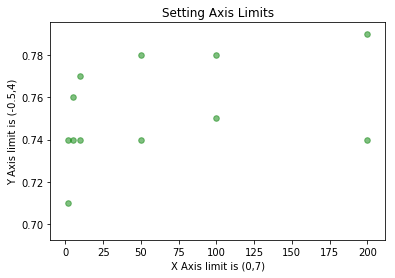

In [20]:
import matplotlib.pyplot as plt
import numpy as np
#import plotly.tools as tls
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api


x = bins
y0 = training_acc
y = test_acc


plt.title('Setting Axis Limits')
#plt.step(x, y)
plt.scatter(x, y, s=area, c='g',alpha=0.5)
plt.scatter(x, y0, s=area, c='g',alpha=0.5)
#y -= 0.5
#plt.step(x, y)

#y -= 0.5
#plt.step(x, y)

#plt.xlim(0, 7) 
#plt.ylim(-0.5, 4)

plt.xlabel('X Axis limit is (0,7)')
plt.ylabel('Y Axis limit is (-0.5,4)')

mpl_fig = plt.gcf()
plt.show()
#plt.savefig('Fig-5_2_Test.png')
plt.close()
#plotly_fig = tls.mpl_to_plotly( mpl_fig )
#plot_url = py.plot(plotly_fig)